In [84]:
# Setup
%matplotlib inline
import os
import sys
import time
import torch
import sklearn
import matplotlib.pyplot as plt

In [85]:
import torch
import torch.autograd as autograd
import torchviz

from torch.optim import LBFGS
from torch.autograd.functional import jacobian, hessian
from torch import Tensor

In [86]:
torch.set_default_dtype(torch.float32)

In [87]:
def elu_forward(z: Tensor, alpha: float):
    elu_positive = z
    elu_negative = alpha * (torch.exp(z) - 1)
    elu = torch.where(z>0, elu_positive, elu_negative)
    return elu

class ELU(torch.nn.Module):
    """
    ELU Activation layer
    """
    def __init__(self, alpha: float = 0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, z: Tensor):
        return elu_forward(z, self.alpha)
    

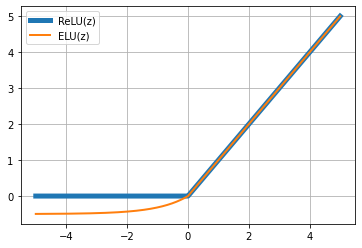

In [88]:
elu = ELU(alpha=0.5)
z = torch.linspace(-5, 5, steps=1000)
plt.plot(z.numpy(), torch.relu(z).numpy(), label='ReLU(z)', linewidth=5);
plt.plot(z.numpy(), elu(z).numpy(), label='ELU(z)', linewidth=2); plt.legend(); plt.grid();

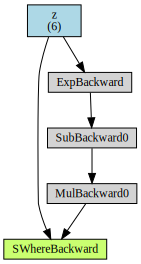

In [89]:
z = torch.tensor([-2., -1, 0, 1, 2, 3], requires_grad=True)
torchviz.make_dot(elu(z), params=dict(z=z))

In [90]:
class ELUFunction(autograd.Function):
    
    @staticmethod
    def forward(ctx, z: Tensor, alpha: float):
        elu = elu_forward(z, alpha)
        ctx.save_for_backward(z)
        ctx.alpha = alpha
        return elu
    
    @staticmethod
    def backward(ctx, grad_output):
        z, = ctx.saved_tensors
        alpha = ctx.alpha
        
        # Caclcualte diagonal of d(elu(z))/dz
        grad_positive = torch.ones_like(z)
        grad_negative = alpha * torch.exp(z)
        
        # Note: This is not the full Jacobian!
        grad_elu = torch.where(z>0, grad_positive, grad_negative)
        
        # Gradient of the loss w.r.t. our output
        δ_elu = grad_output
        
        # Calcualte δz = d(elu(z))/dz * δ_elu
        # Note: elementwise multiplication
        #       equivalant to Jacobian-vector-product
        print(f'{grad_elu.shape=}, {δ_elu.shape=}')
        δz = grad_elu * δ_elu
        return δz, None

In [91]:
class ELUCustom(torch.nn.Module):
    """
    ELU Layer with a custom backward pass
    """
    def __init__(self, alpha: float = 0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, z: Tensor):
        return ELUFunction.apply(z, self.alpha)

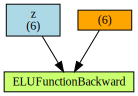

In [92]:
elu_custom = ELUCustom(alpha=0.5)
z = torch.tensor([-2., -1, 0, 1, 2, 3], requires_grad=True)
torchviz.make_dot(elu_custom(z), params=dict(z=z),)

In [93]:
z = torch.randn(8, requires_grad=True)
z1 = z.clone().detach(); z1.requires_grad = True
z2 = z.clone().detach(); z2.requires_grad = True

l1 = torch.sum( elu(z1) )
l2 = torch.sum( elu_custom(z2) )
l1.backward()
l2.backward()

print(f"{z1.grad=}\n{z2.grad=}")

grad_elu.shape=torch.Size([8]), δ_elu.shape=torch.Size([8])
z1.grad=tensor([0.2758, 0.4193, 0.0509, 0.1639, 1.0000, 0.4429, 0.4160, 1.0000])
z2.grad=tensor([0.2758, 0.4193, 0.0509, 0.1639, 1.0000, 0.4429, 0.4160, 1.0000])


In [94]:
l2

tensor(0.1695, grad_fn=<SumBackward0>)

In [95]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

N, D = 100, 10

X, y, w_gt = make_regression(
    n_samples=N, n_features=D, coef=True, random_state=42, bias=10, noise=1,
)

X, y, w_gt = [ torch.from_numpy(t).to(torch.float) for t in [X, y, w_gt] ]

In [96]:

def obj_fun(w: Tensor, µ: Tensor):
    return torch.mean((X @ w - y)**2) + torch.mean(µ * (w ** 2))

w=torch.randn(D) * 0.0001
µ=torch.randn(D) * 0.0001
for x in [w, µ]:
    x.requires_grad_()

obj_fun(w, µ)

tensor(36935.3516, grad_fn=<AddBackward0>)

In [97]:
H = hessian(
obj_fun, inputs=(w, µ), create_graph=False
)

In [98]:
torch.norm(w_gt-w)

tensor(183.7846, grad_fn=<NormBackward0>)

In [99]:

optimizer = LBFGS(params=(w,), lr=0.1, max_iter=1000,)

# Solve the optimization problem
def _optimizer_step():
    # zero grad
    w.grad = torch.zeros_like(w)
    # evaluate loss
    f = obj_fun(w, µ)
    # calulate gradients
    w.grad += autograd.grad(f, (w,), create_graph=False)[0]
    return f

f_min = optimizer.step(_optimizer_step,)
f_min

tensor(36935.3516, grad_fn=<AddBackward0>)

In [100]:
w.grad

tensor([-8.5120e-05, -1.6744e-04, -3.5456e-05, -2.1606e-04, -2.4921e-04,
        -3.1336e-04, -3.0922e-04,  9.9240e-05, -5.2197e-05, -2.1088e-04])

In [101]:
µ.grad

In [102]:
torch.norm(w_gt-w)

tensor(2.0034, grad_fn=<NormBackward0>)

In [19]:
def solve_ls(A: Tensor, B: Tensor, abs: float = 1e-6, rel: float = 1e-6) -> Tensor:
    """
    Solve least squares fit AX=B using SVD and returns X
    :param abs: Absolute threshold to reject small eigenvalues.
    :param rel: Relative threshold to reject small eigenvalues.
    """
    U, S, V = torch.svd(A)
    # th = max(rel * S[0].item(), abs)
    th = torch.max(rel * S[..., 0], torch.tensor(abs))
    Sinv = torch.where(S >= th, 1.0 / S, torch.zeros_like(S))
    return V @ torch.diag(Sinv) @ (U.transpose(1, 0) @ B)


In [20]:
class ArgMinFunction(autograd.Function):
    
    @staticmethod
    def forward(ctx, obj_fun, y, z):
        
        optimizer = LBFGS(params=(y,))
        
        # Solve the optimization problem
        def _optimizer_step():
            # zero gradients
            y.grad = torch.zeros_like(y)
            # evaluate loss
            f = obj_fun(y, z)
            # calculate gradients
            δy = autograd.grad(f, (y,), create_graph=False,)[0]
            # not calling backward() because we don't want to compute
            # gradients for anything except y
            y.grad += δy
            return f
        
        f_min = optimizer.step(_optimizer_step,)
        y_argmin = y # optimized in place
        
        ctx.save_for_backward(y_argmin, z)
        ctx.obj_fun = obj_fun
        
        return y_argmin
    
    @staticmethod
    def backward(ctx, grad_output):
        y_argmin, z = ctx.saved_tensors
        obj_fun = ctx.obj_fun
        
        print(f'*** Argmin Backward ***')
        
        # Hessians
        H = hessian(obj_fun, inputs=(y_argmin, z), create_graph=False)
        Hyy = K = H[0][0]
        Hyz = R = H[0][1]
        
        print(f'{K.shape=}, {R.shape=}')
        
        # Now we need to calculate δz = -R^T K^-1 δy
        # 1. Solve system for δu: K δu = δy
        δy = grad_output
        print(f'{δy.shape=}') 
        
        δy = torch.reshape(δy, (-1, 1))
        δu = solve_ls(K, δy) # solve_ls(A, B) solves A X = B
            
        print(f'{δu.shape=}') 
        
        # 2. Calculate δz = -R^T δu
        δz = -R.transpose(0, 1) @ δu
        
        δz = torch.reshape(δz, z.shape)
        δy = torch.reshape(δy, y_argmin.shape)
        
        return None, δy, δz,
    

In [21]:
print(f'{w=}')
w_argmin = ArgMinFunction.apply(obj_fun, w, µ)
w_argmin

w=tensor([17.0892, 54.7262,  4.3599, 62.8702, 93.1555, 71.7873, 87.2718, 10.2929,
         3.9739, 70.8241], requires_grad=True)


tensor([17.0897, 54.7279,  4.3601, 62.8722, 93.1586, 71.7895, 87.2747, 10.2934,
         3.9740, 70.8266], grad_fn=<ArgMinFunctionBackward>)

In [22]:
l = torch.sum(w_argmin)
l

tensor(476.3669, grad_fn=<SumBackward0>)

In [23]:
print(f'{w.grad=}')
print(f'{µ.grad=}')

w.grad=tensor([ 9.7351e-07, -2.9023e-06, -4.5134e-06,  3.6639e-07,  9.3856e-06,
        -3.2128e-06, -1.0072e-05,  5.7760e-07, -4.4328e-06, -5.8208e-11])
µ.grad=None


In [24]:
µ.grad=None
w.grad=None
l.backward()

*** Argmin Backward ***
K.shape=torch.Size([10, 10]), R.shape=torch.Size([10, 10])
δy.shape=torch.Size([10])
δu.shape=torch.Size([10, 1])


In [25]:
µ

tensor([-6.6035e-05, -3.6560e-05, -4.4205e-05,  2.3370e-05,  9.0174e-05,
         6.6870e-05,  2.1953e-04, -1.1069e-05,  2.5596e-06,  2.6686e-05],
       requires_grad=True)

In [26]:
µ.grad

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [27]:
w.grad

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [28]:
class BaseArgMinLayer(torch.nn.Module):
    
    def __init__(self, y: Tensor):
        super().__init__()
        self.y = torch.nn.Parameter(y, requires_grad=True)
    
    def obj_fun(self, y, z):
        raise NotImplementedError("Should be overridden by subclass")
    
    def forward(self, z: Tensor):
        obj_fn = lambda y, z: self.obj_fun(y, z)
        y_argmin = ArgMinFunction.apply(obj_fn, self.y, z)
        return y_argmin
    

In [29]:
import pandas as pd
import numpy as np

In [30]:
stock_names = ["AAPL", "GOOGL", "MSFT", "AMZN"]
df = pd.read_csv("DJIA_30/all_stocks_2006-01-01_to_2018-01-01.csv")
# df = df[df['Name'].isin(stock_names)]
df.shape

(93612, 7)

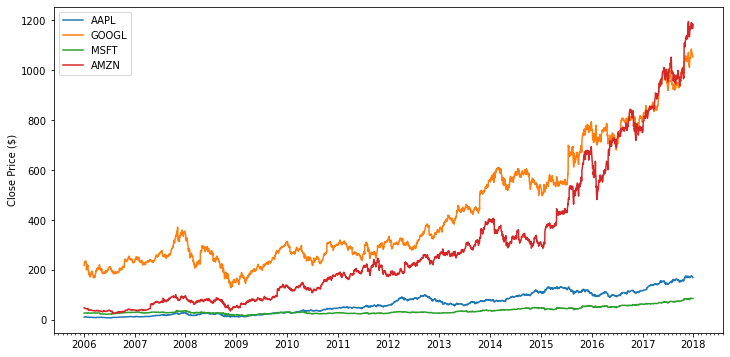

In [31]:
import matplotlib.dates as mdates
from datetime import datetime

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
for stock_name in stock_names:
    df_stock = df[df['Name'] == stock_name]
    df_stock_dates = [datetime.strptime(d,'%Y-%m-%d').date() for d in df_stock['Date']]
    ax.plot(df_stock_dates, df_stock['Close'], label=stock_name)
ax.set_ylabel('Close Price ($)'); ax.legend();

In [32]:

SEG_LEN = 40
SEG_BASE = 30
SEG_TARGET = SEG_LEN - SEG_BASE

X = torch.tensor(df['Close'].values, dtype=torch.float)
X = X[0:SEG_LEN*(X.shape[0]//SEG_LEN)]
X = torch.reshape(X, (-1, 1, SEG_LEN)) # adding channel dimension
X, Y = X[..., :SEG_BASE], X[..., SEG_BASE:]

X.shape, Y.shape

(torch.Size([2340, 1, 30]), torch.Size([2340, 1, 10]))

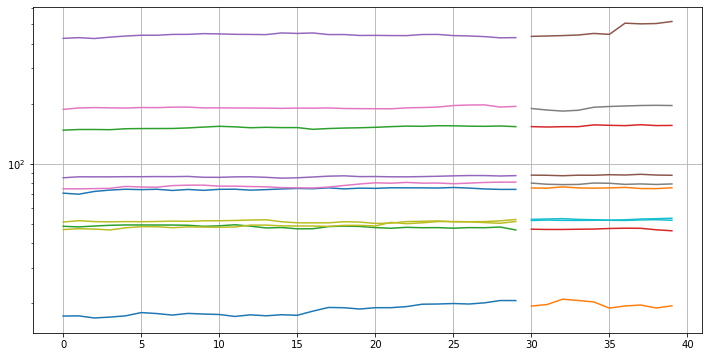

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
idx_perm = np.random.permutation(range(X.shape[0]))
for i in range(10):
    ax.semilogy(range(SEG_BASE), X[idx_perm[i], 0, :])
    ax.semilogy(range(SEG_BASE, SEG_LEN), Y[idx_perm[i], 0, :])
ax.grid();

In [34]:
from torch.utils.data import TensorDataset, DataLoader

In [35]:
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=8, shuffle=True)

In [36]:
class EncDec(torch.nn.Module):
    def __init__(self, channels=[1, 4, 8], out_nl=True):
        super().__init__()
        
        layers = []
        channel_pairs = zip(channels[:-1], channels[1:])
        for in_channels, out_channels in channel_pairs:
            layers.extend([
                torch.nn.Conv1d(
                    in_channels, out_channels,
                    kernel_size=3, padding=1, bias=True
                ),
                ELUCustom(alpha=0.5),
            ])
        if not out_nl:
            layers = layers[:-1]
            
        self.layers = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)
        

In [47]:
enc = EncDec(channels=[1, 4, 1], out_nl=True)
enc

EncDec(
  (layers): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ELUCustom()
    (2): Conv1d(4, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ELUCustom()
  )
)

In [48]:
x0, y0 = next(iter(dl))
x0.shape

torch.Size([8, 1, 30])

In [49]:
enc(x0).shape

torch.Size([8, 1, 30])

In [64]:
class Predictor(torch.nn.Module):
    def __init__(self, postiction_len, prediction_len):
        super().__init__()
        self.postiction_len = postiction_len
        self.prediction_len = prediction_len
        self.w = torch.randn(1, postiction_len, prediction_len, requires_grad=True)
    
    def argmin_forward(w, x_emb):
        pass
    
    def forward(self, x_emb):
        # x_emb has shape (N, C, S)
        
        def _argmin_obj_fn(w, z):
            emb_post = z[..., :self.postiction_len]
            emb_post_target = z[..., self.postiction_len:]
            return torch.mean((torch.matmul(emb_post, w) - emb_post_target)**2)
        
        # Solve optimization problem to find w*
        w_opt = ArgMinFunction.apply(_argmin_obj_fn, self.w, x_emb)
        
        # Use w* to predict
        x_emb_predict = x_emb[..., -self.postiction_len:]
        return torch.matmul(x_emb_predict, w_opt)
        

In [65]:
pred = Predictor(postiction_len=SEG_BASE-10, prediction_len=SEG_TARGET)

In [66]:
pred(enc(x0)).shape

torch.Size([8, 1, 10])

In [67]:
dec = EncDec(channels=[1, 4, 1], out_nl=False)
dec

EncDec(
  (layers): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ELUCustom()
    (2): Conv1d(4, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
)

In [68]:
dec(pred(enc(x0))).shape

torch.Size([8, 1, 10])

In [69]:
loss = torch.mean(dec(pred(enc(x0))))
loss

tensor(0.1775, grad_fn=<MeanBackward0>)

In [70]:
with autograd.detect_anomaly():
    loss = torch.mean(dec(pred(enc(x0))))
    loss.backward()

<ipython-input-70-5323645efdc5>:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with autograd.detect_anomaly():


grad_elu.shape=torch.Size([8, 4, 10]), δ_elu.shape=torch.Size([8, 4, 10])
*** Argmin Backward ***
K.shape=torch.Size([1, 20, 10, 1, 20, 10]), R.shape=torch.Size([1, 20, 10, 8, 1, 30])
δy.shape=torch.Size([1, 20, 10])


RuntimeError: The size of tensor a (10) must match the size of tensor b (20) at non-singleton dimension 2